In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [8]:
!pip install rake-nltk # Extract keywords

In [9]:
!pip install pyLDAvis # Topic Modeling

## Load library

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.cluster import DBSCAN # Find similar papers
from nltk.corpus import stopwords
from spacy.matcher import Matcher 
from collections import  Counter
import matplotlib.pyplot as plt
from spacy.tokens import Span 
import tensorflow_hub as hub
from rake_nltk import Rake
import tensorflow as tf
import pyLDAvis.gensim_models
from tqdm import tqdm
import seaborn as sns
import networkx as nx
import pandas as pd
import numpy as np
import pyLDAvis
import gensim
import spacy
import os
import gc

## Load data and explore it

In [11]:
path = "/content/gdrive/MyDrive/Project2-KG/input/CORD-19-research-challenge/"
all_sources = pd.read_csv(path + "metadata.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
all_sources.isna().sum() # Title's missing a little, but abstract's very much

cord_uid                 0
sha                 385365
source_x                 0
title                  289
doi                 267593
pmcid               376652
pubmed_id           310102
license                  0
abstract            156200
publish_time           219
authors              15278
journal              38168
mag_id              579255
who_covidence_id    332197
arxiv_id            571658
pdf_json_files      385365
pmc_json_files      422901
url                 245415
s2_id                50850
dtype: int64

### Dist plot of title length

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


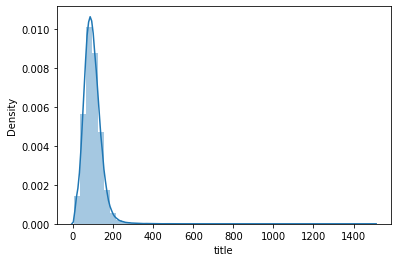

<Figure size 648x504 with 0 Axes>

In [13]:
headline_length = all_sources['title'].str.len()
sns.distplot(headline_length)
plt.figure(figsize=(9,7))
plt.show()

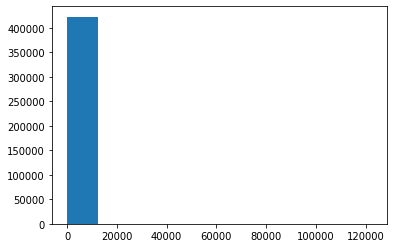

In [14]:
headline_length=all_sources['abstract'].str.len()
plt.hist(headline_length)
plt.show()

### Build word corpus for title and abstract

In [15]:
# url : https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools
stop = set(stopwords.words('english'))

def build_list(df,col="title"):
    corpus  =[]
    lem = WordNetLemmatizer()
    stop = set(stopwords.words('english'))
    new = df[col].dropna().str.split()
    new = new.values.tolist()
    corpus = [lem.lemmatize(word.lower()) for i in new for word in i if(word) not in stop]
    
    return corpus

In [16]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [17]:
corpus = build_list(all_sources)

### Which are most common words in title?¶


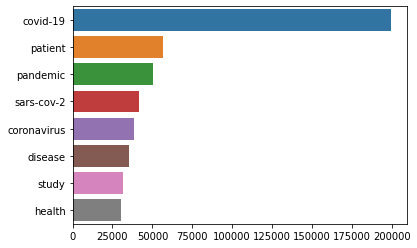

In [18]:
counter = Counter(corpus)
most = counter.most_common()

x, y= [], []
for word,count in most[:10]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

In [19]:
abstract = build_list(all_sources[:1600], 'abstract')


### Which are most common words in abtract(first 1600 papers)?¶

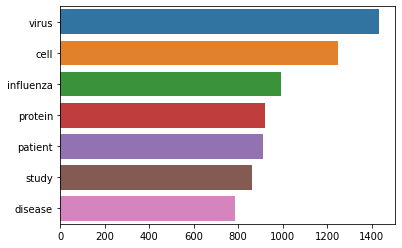

In [20]:
counter = Counter(abstract)
most = counter.most_common()

x, y= [], []
for word,count in most[:10]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

In [26]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

### Which are most common bi-grams in titles?

```
# Định dạng của đoạn này là mã
```

 in title?¶

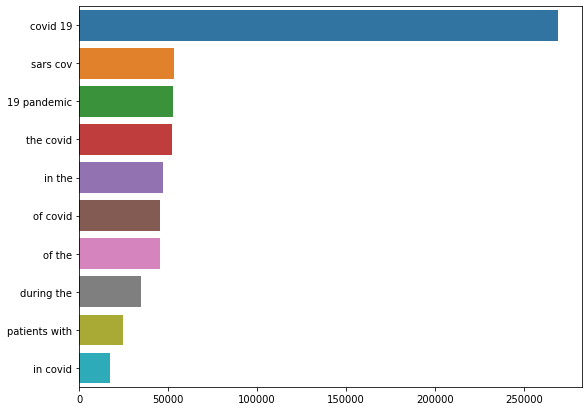

In [27]:
top_n_bigrams=get_top_ngram(all_sources['title'].dropna(),2)[:10]
x,y=map(list,zip(*top_n_bigrams))
plt.figure(figsize=(9,7))
sns.barplot(x=y,y=x)

### Which are most common tri-grams in title?

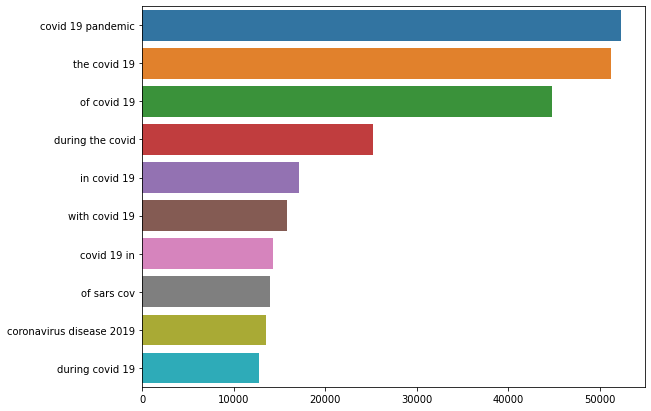

In [28]:
top_tri_grams=get_top_ngram(all_sources['title'].dropna(),n=3)
x,y=map(list,zip(*top_tri_grams))
plt.figure(figsize=(9,7))
sns.barplot(x=y,y=x)

### Using LDA for topic Modeling

In [41]:
def preprocess_title(df):
    corpus=[]
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    for title in df['title']:
        words=[w for w in word_tokenize(str(title)) if (w not in stop)]
        
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        
        corpus.append(words)
    return corpus

In [42]:
corpus = preprocess_title(all_sources[:1600])

In [43]:
dic=gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

In [45]:
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 4)

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.s

In [46]:
lda_model.show_topics()

[(0,
  '0.012*"Virus" + 0.011*"Influenza" + 0.006*"Human" + 0.004*"Disease" + 0.004*"H5N1" + 0.004*"H1N1" + 0.004*"Analysis" + 0.003*"Cells" + 0.003*"Vaccine" + 0.003*"infection"'),
 (1,
  '0.015*"Virus" + 0.008*"The" + 0.008*"Influenza" + 0.008*"Infection" + 0.006*"Human" + 0.006*"Respiratory" + 0.004*"Gene" + 0.003*"Cells" + 0.003*"Disease" + 0.003*"Identification"'),
 (2,
  '0.013*"influenza" + 0.007*"infection" + 0.006*"disease" + 0.005*"The" + 0.005*"Protein" + 0.005*"study" + 0.004*"pandemic" + 0.004*"H1N1" + 0.004*"patient" + 0.004*"health"'),
 (3,
  '0.009*"virus" + 0.006*"respiratory" + 0.006*"acute" + 0.006*"influenza" + 0.006*"The" + 0.005*"H1N1" + 0.005*"study" + 0.004*"Infection" + 0.004*"patient" + 0.004*"2009"')]

In [48]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dic)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.062957  0.098333       1        1  26.307342
2     -0.092175  0.016309       2        1  25.253649
1      0.085941 -0.078438       3        1  24.381659
3     -0.056723 -0.036203       4        1  24.057350, topic_info=             Term        Freq       Total Category  logprob  loglift
103     influenza   79.000000   79.000000  Default  30.0000  30.0000
204         Virus  130.000000  130.000000  Default  29.0000  29.0000
525         acute   26.000000   26.000000  Default  28.0000  28.0000
1009  Respiratory   29.000000   29.000000  Default  27.0000  27.0000
200     Infection   56.000000   56.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
187         Human   11.281742   69.240054   Topic4  -5.8030  -0.3897
686         Cells    9.435502   43.511561   Topic4  -5.9817  -0.1038
358          Cell    7.921947   30.657027   Topic4  -6.1565   0.0715
204         Virus    9.582792  130.060733   Topic4  -5.9662  -1.1833
157       Protein    7.921216   44.921060   Topic4  -6.1566  -0.3106

[312 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1421      1  0.238254    2009
1421      2  0.370617    2009
1421      4  0.370617    2009
865       1  0.333934   Acute
865       3  0.534294   Acute
...     ...       ...     ...
86        1  0.134154   virus
86        2  0.251539   virus
86        3  0.067077   virus
86        4  0.536616   virus
352       2  0.873452  worker

[500 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 4])

In [49]:
del corpus,top_n_bigrams,lda_model,bow_corpus,top_tri_grams
gc.collect()

2319